Preprocessing based on suggestions from Google Gemini

based on https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

and https://www.10xgenomics.com/analysis-guides/common-considerations-for-quality-control-filters-for-single-cell-rna-seq-data

Code in this notebook primarily generated using Gemini 3.0

In [1]:
import anndata as ad
import dask.array as da
import h5py
import numpy as np
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

datadir = Path('/Users/poldrack/data_unsynced/BCBS/immune_aging/')

In [2]:
adata = ad.read_h5ad(datadir / 'dataset-OneK1K_subset-immune_filtered.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 785021 × 29331
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_counts'
    uns: 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_azimuth_spca', 'X_azimuth_uma

In [3]:
var_to_feature = dict(zip(adata.var_names, adata.var['feature_name']))


### Quality control

based on https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html


In [4]:
# mitochondrial genes
adata.var["mt"] = adata.var['feature_name'].str.startswith("MT-")
print(f"Number of mitochondrial genes: {adata.var['mt'].sum()}")

# ribosomal genes
adata.var["ribo"] = adata.var['feature_name'].str.startswith(("RPS", "RPL"))
print(f"Number of ribosomal genes: {adata.var['ribo'].sum()}")

# hemoglobin genes.
adata.var["hb"] = adata.var['feature_name'].str.contains("^HB[^(P)]")
print(f"Number of hemoglobin genes: {adata.var['hb'].sum()}")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)



Number of mitochondrial genes: 13
Number of ribosomal genes: 107
Number of hemoglobin genes: 12


#### Visualization of distributions 

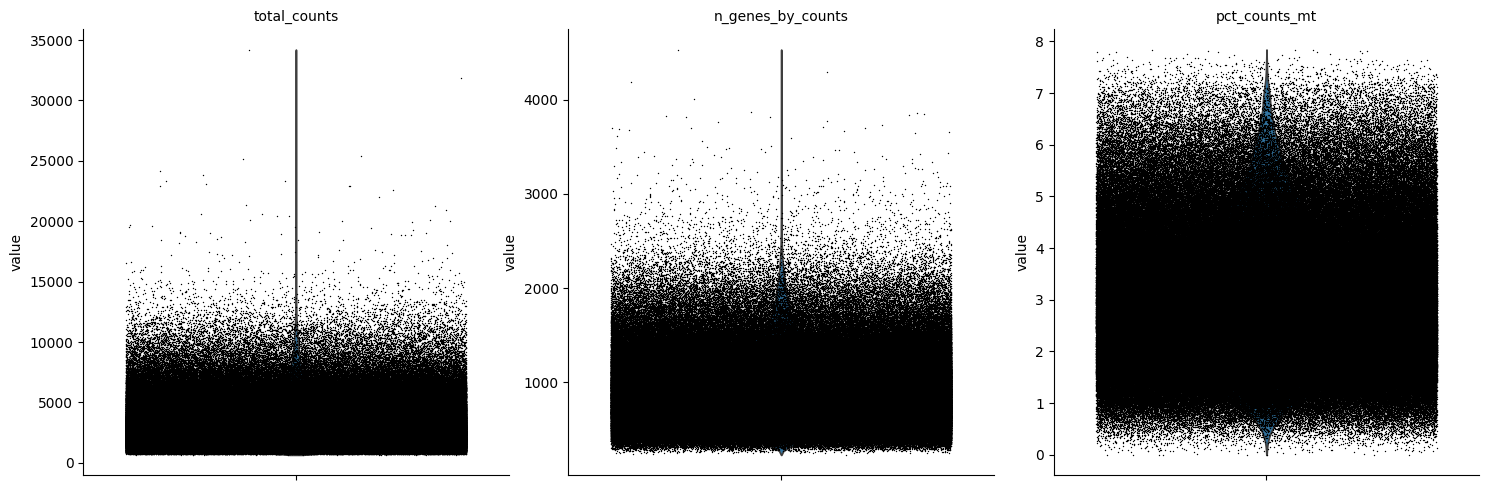

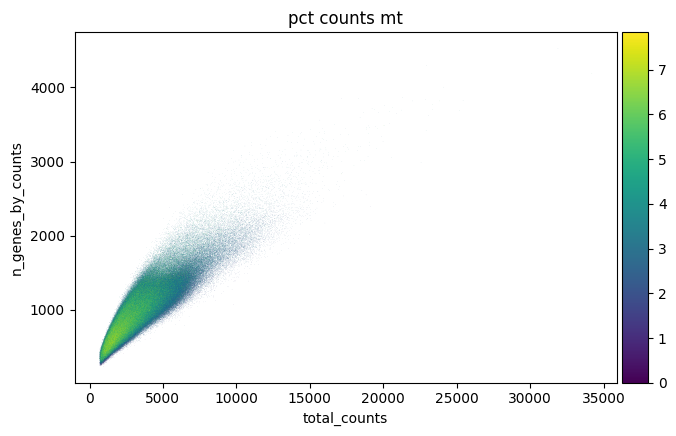

In [5]:

# 1. Violin plots to see the distribution of QC metrics
# Note: I am using the exact column names from your adata output
p1 = sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# 2. Scatter plot to spot doublets and dying cells
# High mito + low genes = dying cell
# High counts + high genes = potential doublet
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

####  Check Hemoglobin (RBC contamination)


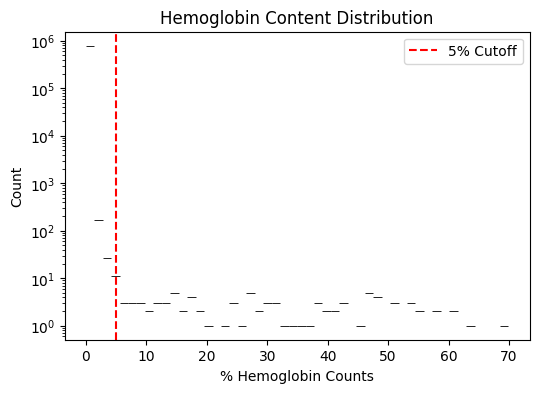

In [6]:

plt.figure(figsize=(6, 4))
sns.histplot(adata.obs['pct_counts_hb'], bins=50, log_scale=(False, True)) # Log scale y to see small RBC populations
plt.title("Hemoglobin Content Distribution")
plt.xlabel("% Hemoglobin Counts")
plt.axvline(5, color='red', linestyle='--', label='5% Cutoff')
plt.legend()
plt.show()

#### Create a copy of the data and apply QC cutoffs


In [7]:
# Create a copy or view to avoid modifying the original if needed
adata_qc = adata.copy()

# --- Define Thresholds ---
# Low quality (Empty droplets / debris)
min_genes = 200       # Standard for immune cells (T-cells can be small)
min_counts = 500      # Minimum UMIs

# Doublets (Two cells stuck together)
# Adjust this based on the scatter plot above. 
# 4000-6000 is common for 10x Genomics data.
max_genes = 6000      
max_counts = 30000    # Very high counts often indicate doublets

# Contaminants
max_hb_pct = 5.0      # Remove Red Blood Cells (> 5% hemoglobin)

# --- Apply Filtering ---
print(f"Before filtering: {adata_qc.n_obs} cells")

# 1. Filter Low Quality & Doublets
adata_qc = adata_qc[
    (adata_qc.obs['n_genes_by_counts'] > min_genes) &
    (adata_qc.obs['n_genes_by_counts'] < max_genes) &
    (adata_qc.obs['total_counts'] > min_counts) &
    (adata_qc.obs['total_counts'] < max_counts)
]

# 2. Filter Red Blood Cells (Hemoglobin)
# Only run this if you want to remove RBCs
adata_qc = adata_qc[adata_qc.obs['pct_counts_hb'] < max_hb_pct]

print(f"After filtering: {adata_qc.n_obs} cells")

Before filtering: 785021 cells
After filtering: 784929 cells


### Perform doublet detection

According to Gemini:

You must do this before normalization or clustering because doublets create "hybrid" expression profiles that can form fake clusters (e.g., a "cluster" that looks like a mix of T-cells and B-cells) or distort your normalization factors.

**Important: Run Per Donor**

Since you have multiple people, you must run doublet detection separately for each donor. The doublet rate is a technical artifact of the physical loading of the machine (10x Genomics chip), which varies per run. If you run it on the whole dataset at once, the algorithm will get confused by biological differences between people.


In [8]:

# 1. Check preliminary requirements
# Scrublet needs RAW counts. Ensure adata.X contains integers, not log-normalized data.
# If your main layer is already normalized, use adata.raw or a specific layer.
print(f"Data shape before doublet detection: {adata_qc.shape}")

# 2. Run Scrublet per donor
# We split the data, run detection, and then recombine.
# This prevents the algorithm from comparing a cell from Person A to a cell from Person B.

adatas_list = []
# Get list of unique donors
donors = adata_qc.obs['donor_id'].unique()

print(f"Running Scrublet on {len(donors)} donors...")

for donor in donors:
    # Subset to current donor
    curr_adata = adata_qc[adata_qc.obs['donor_id'] == donor].copy()
    
    # Skip donors with too few cells (Scrublet needs statistical power)
    if curr_adata.n_obs < 100:
        print(f"Skipping donor {donor}: too few cells ({curr_adata.n_obs})")
        # We still add it back to keep the data, but mark as singlet (or filter later)
        curr_adata.obs['doublet_score'] = 0
        curr_adata.obs['predicted_doublet'] = False
        adatas_list.append(curr_adata)
        continue

    # Run Scrublet
    # expected_doublet_rate=0.06 is standard for 10x (approx ~0.8% per 1000 cells recovered)
    # If you loaded very heavily (20k cells/well), increase this to 0.10
    sc.pp.scrublet(curr_adata, expected_doublet_rate=0.06)
    
    adatas_list.append(curr_adata)

# 3. Merge back into one object
adata_qc = sc.concat(adatas_list)

# 4. Check results
print(f"Detected {adata_qc.obs['predicted_doublet'].sum()} doublets across all donors.")
print(adata_qc.obs['predicted_doublet'].value_counts())

Data shape before doublet detection: (784929, 29331)
Running Scrublet on 698 donors...
Detected 7335 doublets across all donors.
predicted_doublet
False    777594
True       7335
Name: count, dtype: int64


#### Visualize doublets



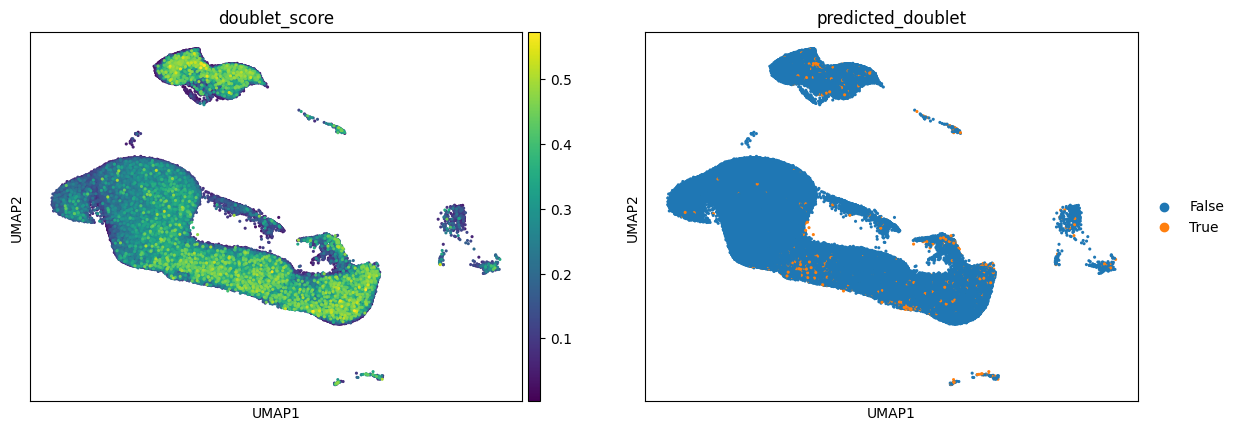

In [9]:
sc.pl.umap(adata_qc, color=['doublet_score', 'predicted_doublet'], size=20)

#### Filter doublets
- Question: how consistent are these results with other methods for doublet detection? https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#doublet-detection

In [10]:
# Check how many doublets were found
print(f'found {adata_qc.obs["predicted_doublet"].sum()} predicted doublets')

# Filter the data to keep only singlets (False)
# write back to adata for simplicity
adata = adata_qc[adata_qc.obs['predicted_doublet'] == False, :]
print(f"Remaining cells: {adata.n_obs}")

found 7335 predicted doublets
Remaining cells: 777594


#### Save raw counts for later use

In [11]:
#  set the .raw attribute (standard Scanpy convention)
adata.layers['counts'] = adata.X.copy()

/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_48619/871672687.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()


### Total Count Normalization
This scales each cell so that they all have the same total number of counts (default is often 10,000, known as "CP10k").

In [12]:
# Normalize to 10,000 reads per cell
# target_sum=1e4 is the standard for 10x data
sc.pp.normalize_total(adata, target_sum=1e4)

### Log Transformation (Log1p)
This applies a natural logarithm to the data:  log(X+1). This reduces the skewness of the data (since gene expression follows a power law) and stabilizes the variance.

In [13]:
# Logarithmically transform the data
sc.pp.log1p(adata)

### select high-variance features

according to Gemini:
For a large immune dataset (PBMCs, ~1.2M cells), the standard defaults often fail to capture the subtle biological variation needed to distinguish similar cell types (like CD4+ T-cell subsets).

Here are the reasonable parameters and, more importantly, the **immune-specific strategy** you should use.

#### The Recommended Parameters

For a dataset of your size, the **`seurat_v3`** flavor is generally superior because it selects genes based on standardized variance (handling the mean-variance relationship better than the dispersion-based method).

*   **`flavor`**: `'seurat_v3'` (Requires **RAW integer counts** in `adata.X` or a layer)
*   **`n_top_genes`**: **2000 - 3000** (3000 is safer for immune data to capture rare cytokines/markers)
*   **`batch_key`**: **`'donor_id'`** (CRITICAL)
    *   *Why?* With 1.2M cells across many people, you have massive batch effects. If you don't set this, "highly variable genes" will just be the genes that differ between Person A and Person B (e.g., HLA genes, gender-specific genes like XIST/RPS4Y1), rather than genes distinguishing cell types.

#### The "Expert" Trick: Blocklisting Nuisance Genes
In immune datasets, "highly variable" does not always mean "biologically interesting." You often need to **exclude** specific gene families from the HVG list *after* calculation but *before* PCA, or they will hijack your clustering:
1.  **TCR/BCR Variable Regions (IG*, TR*):** These are hyper-variable by definition (V(D)J recombination). If you keep them, T-cells will cluster by **clone** (clonotype) rather than by **phenotype** (state).
2.  **Mitochondrial/Ribosomal:** Usually technical noise.
3.  **Cell Cycle:** (Optional) If you don't want proliferating cells to cluster separately.



#### Why 3000 genes instead of 2000?
Immune cells are dense with specific markers. The difference between a *Naive CD8 T-cell* and a *Central Memory CD8 T-cell* might rest on a handful of genes (e.g., *CCR7, SELL, IL7R* vs *GZMK*). If you limit to 2000 genes in a massive, diverse dataset, you might accidentally drop a subtle marker required to resolve these fine-grained states.

In [14]:

import scanpy as sc
import pandas as pd


# 2. Run Highly Variable Gene Selection
# batch_key is critical here to find genes variable WITHIN donors, not BETWEEN them.
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    flavor='seurat_v3',
    batch_key='donor_id',
    span=0.8,  # helps avoid numerical issues with LOESS
    layer='counts',  # Change this to None if adata.X is raw counts
    subset=False     # Keep False so we can manually filter the list below
)

# 3. Filter out "Nuisance" Genes from the HVG list
# We don't remove the genes from the object, we just set their 'highly_variable' status to False
# so they aren't used in PCA.

# A. Identify TCR/BCR genes (starts with IG or TR)
# Regex: IG or TR followed by a V, D, J, or C gene part
import re
immune_receptor_genes = [
    name for name in adata.var_names 
    if re.match(r'^(IG[HKL]|TR[ABDG])[VDJC]', name)
]

# B. Identify Ribosomal/Mitochondrial (if not already handled)
mt_genes = adata.var_names[adata.var_names.str.startswith('MT-')]
rb_genes = adata.var_names[adata.var_names.str.startswith(('RPS', 'RPL'))]

# C. Manually set them to False
genes_to_block = list(immune_receptor_genes) + list(mt_genes) + list(rb_genes)

# Using set operations for speed
adata.var.loc[adata.var_names.isin(genes_to_block), 'highly_variable'] = False

print(f"Blocked {len(immune_receptor_genes)} immune receptor genes from HVG list.")
print(f"Final HVG count: {adata.var['highly_variable'].sum()}")

# 4. Proceed to PCA
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)


Blocked 0 immune receptor genes from HVG list.
Final HVG count: 3000


/Users/poldrack/Dropbox/code/BetterCodeBetterScience/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


### Dimensionality reduction

In [15]:
import scanpy.external as sce

# 1. Run Harmony
# This adjusts the PCA coordinates to mix donors together while preserving biology.
# It creates a new entry in obsm: 'X_pca_harmony'
try:
    sce.pp.harmony_integrate(adata, key='donor_id', basis='X_pca', adjusted_basis='X_pca_harmony')
    use_rep = 'X_pca_harmony'
    print("Harmony integration successful. Using corrected PCA.")
except ImportError:
    print("Harmony not installed. Proceeding with standard PCA (Warning: Batch effects may persist).")
    print("To install: pip install harmony-pytorch")
    use_rep = 'X_pca'

2025-12-20 10:37:58,784 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-12-20 10:38:23,074 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-20 10:38:25,994 - harmonypy - INFO - Iteration 1 of 10
2025-12-20 10:49:03,832 - harmonypy - INFO - Iteration 2 of 10
2025-12-20 10:59:50,478 - harmonypy - INFO - Iteration 3 of 10
2025-12-20 11:10:24,641 - harmonypy - INFO - Iteration 4 of 10
2025-12-20 11:20:50,945 - harmonypy - INFO - Iteration 5 of 10
2025-12-20 11:30:24,097 - harmonypy - INFO - Converged after 5 iterations


Harmony integration successful. Using corrected PCA.


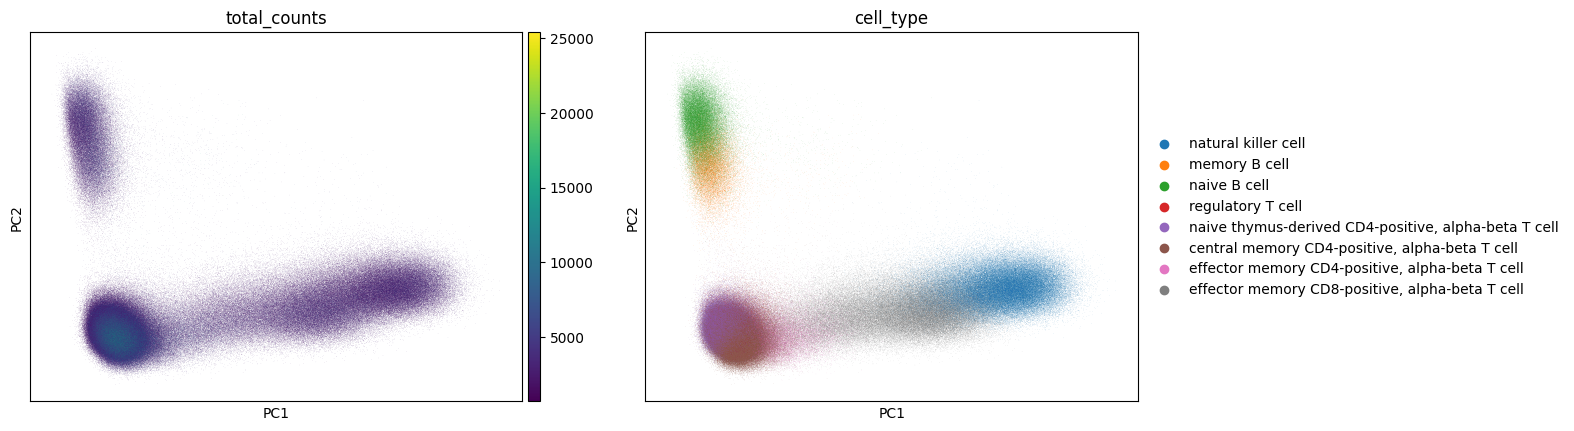

In [16]:
# Reality check: Check if PC1 is just "Cell Size":

sc.pl.pca(adata, color=['total_counts', 'cell_type'], components=['1,2'])

PC1 separates cell types and isn't driven only by the number of cells.

In [17]:
# 2. Compute Neighbors
# n_neighbors: 15-30 is standard. Higher (30-50) is better for large datasets to preserve global structure.
# n_pcs: 30-50 is standard.
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=40, use_rep=use_rep)

# 3. Compute UMAP
# This projects the graph into 2D for you to look at.
sc.tl.umap(adata, init_pos='X_pca_harmony')

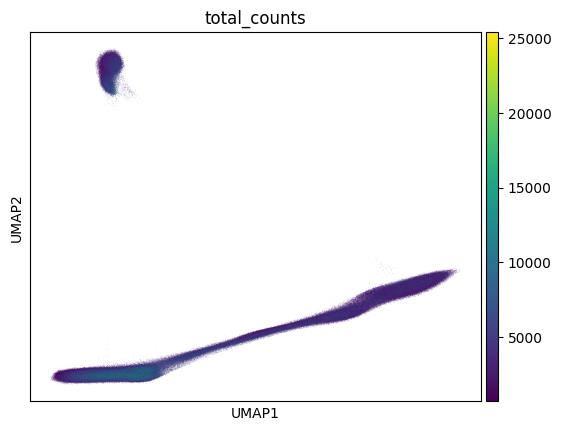

In [18]:
sc.pl.umap(adata, color="total_counts")


### Clustering


In [19]:
# 4. Run Clustering (Leiden algorithm)
# We run multiple resolutions so you can choose the best one later.
#sc.tl.leiden(adata, resolution=0.5, key_added='leiden_0.5')
sc.tl.leiden(adata, resolution=1.0, key_added='leiden_1.0',
    flavor="igraph", n_iterations=2)


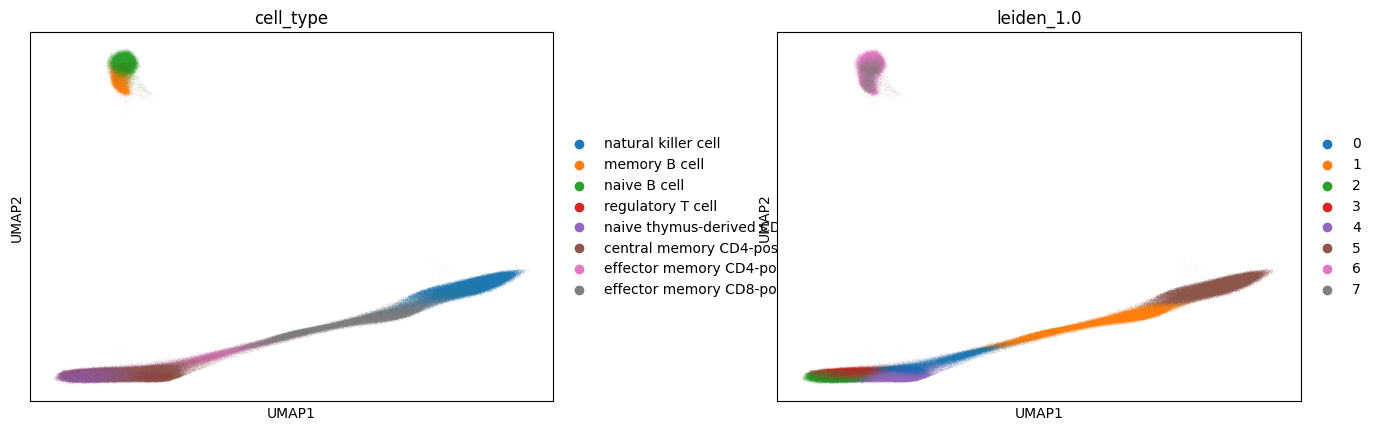

In [20]:
# Plot UMAP colored by Donor (to check integration) and Clusters
sc.pl.umap(adata, color=['cell_type', 'leiden_1.0'], wspace=0.3)

In [21]:
# compute overlap between clusters and cell types
contingency_table = pd.crosstab(adata.obs['leiden_1.0'], adata.obs['cell_type'])
print(contingency_table)

cell_type   natural killer cell  memory B cell  naive B cell  \
leiden_1.0                                                     
0                            16              0             0   
1                          3307              0             0   
2                             4              2             0   
3                             0              0             0   
4                             1              4             0   
5                        115151              0             7   
6                             4          13789         31184   
7                             3           9320         19541   

cell_type   regulatory T cell  \
leiden_1.0                      
0                         562   
1                          24   
2                        6528   
3                        5765   
4                        8161   
5                           1   
6                          67   
7                          29   

cell_type   naive thymus-der

### Pseudobulking

In [22]:
import pandas as pd
import numpy as np
import anndata as ad
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder

def create_pseudobulk(adata, group_col, donor_col, layer='counts', metadata_cols=None):
    """
    Sum raw counts for each (Donor, CellType) pair.
    
    Parameters:
    -----------
    adata : AnnData
        Input single-cell data
    group_col : str
        Column name for grouping (e.g., 'cell_type')
    donor_col : str
        Column name for donor ID
    layer : str
        Layer to use for aggregation (default: 'counts')
    metadata_cols : list of str, optional
        Additional metadata columns to preserve from obs (e.g., ['development_stage', 'sex'])
        These should have consistent values within each donor
    """
    # 1. Create a combined key (e.g., "Bcell::Donor1")
    groups = adata.obs[group_col].astype(str)
    donors = adata.obs[donor_col].astype(str)
    
    # Create a DataFrame to manage the unique combinations
    group_df = pd.DataFrame({'group': groups, 'donor': donors})
    group_df['combined'] = group_df['group'] + "::" + group_df['donor']
    
    # 2. Build the Aggregation Matrix (One-Hot Encoding)
    enc = OneHotEncoder(sparse_output=True, dtype=np.float32)
    membership_matrix = enc.fit_transform(group_df[['combined']])
    
    # 3. Aggregation (Summing)
    if layer is not None and layer in adata.layers:
        X_source = adata.layers[layer]
    else:
        X_source = adata.X
        
    pseudobulk_X = membership_matrix.T @ X_source
    
    # 4. Create the Obs Metadata for the new object
    unique_ids = enc.categories_[0]
    
    # Split back into Donor and Cell Type
    obs_data = []
    for uid in unique_ids:
        ctype, donor = uid.split("::")
        obs_data.append({'cell_type': ctype, 'donor_id': donor})
    
    pb_obs = pd.DataFrame(obs_data, index=unique_ids)
    
    # 5. Count how many cells went into each sum
    cell_counts = np.array(membership_matrix.sum(axis=0)).flatten()
    pb_obs['n_cells'] = cell_counts.astype(int)
    
    # 6. Add additional metadata columns
    if metadata_cols is not None:
        for col in metadata_cols:
            if col in adata.obs.columns:
                # For each pseudobulk sample, get the first (should be consistent) value
                # from the original data for that donor
                col_values = []
                for uid in unique_ids:
                    ctype, donor = uid.split("::")
                    # Get value from any cell with this donor (should all be the same)
                    donor_mask = adata.obs[donor_col] == donor
                    if donor_mask.any():
                        col_values.append(adata.obs.loc[donor_mask, col].iloc[0])
                    else:
                        col_values.append(None)
                pb_obs[col] = col_values
    
    # 7. Assemble the AnnData
    pb_adata = ad.AnnData(X=pseudobulk_X, obs=pb_obs, var=adata.var.copy())
    
    return pb_adata

# --- Execute ---

target_cluster_col = 'cell_type'

print("Aggregating counts...")
pb_adata = create_pseudobulk(
    adata, 
    group_col=target_cluster_col, 
    donor_col='donor_id', 
    layer='counts',
    metadata_cols=['development_stage', 'sex']  # Add any other donor-level metadata here
)

print(f"Pseudobulk complete.")
print(f"Original shape: {adata.shape}")
print(f"Pseudobulk shape: {pb_adata.shape} (Samples x Genes)")
print(pb_adata.obs.head())

Aggregating counts...
Pseudobulk complete.
Original shape: (777594, 29331)
Pseudobulk shape: (5584, 29331) (Samples x Genes)
                                                                                         cell_type  \
central memory CD4-positive, alpha-beta T cell:...  central memory CD4-positive, alpha-beta T cell   
central memory CD4-positive, alpha-beta T cell:...  central memory CD4-positive, alpha-beta T cell   
central memory CD4-positive, alpha-beta T cell:...  central memory CD4-positive, alpha-beta T cell   
central memory CD4-positive, alpha-beta T cell:...  central memory CD4-positive, alpha-beta T cell   
central memory CD4-positive, alpha-beta T cell:...  central memory CD4-positive, alpha-beta T cell   

                                                     donor_id  n_cells  \
central memory CD4-positive, alpha-beta T cell:...  1000_1001      562   
central memory CD4-positive, alpha-beta T cell:...  1001_1002      392   
central memory CD4-positive, alpha-beta 

Dropping samples with < 10 cells...
Remaining samples: 5561


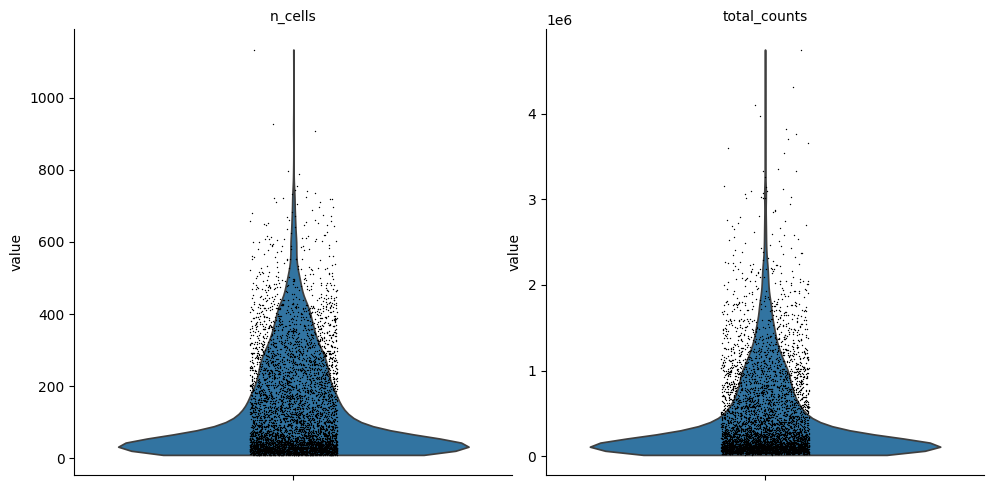

In [23]:
min_cells = 10
print(f"Dropping samples with < {min_cells} cells...")

pb_adata = pb_adata[pb_adata.obs['n_cells'] >= min_cells].copy()

print(f"Remaining samples: {pb_adata.n_obs}")

# Optional: Visualize the 'depth' of your new pseudobulk samples
import scanpy as sc
pb_adata.obs['total_counts'] = np.array(pb_adata.X.sum(axis=1)).flatten()
sc.pl.violin(pb_adata, ['n_cells', 'total_counts'], multi_panel=True)

### Differential expression with age

First need to z-score the age variable to put it on same scale as expression, to help with convergence

In [24]:
# first need to create 'age_scaled' variable from 'development_stage'
# eg. from '19-year-old stage' to 19
ages = pb_adata.obs['development_stage'].str.extract(r'(\d+)-year-old').astype(float)
pb_adata.obs['age'] = ages



In [25]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from sklearn.preprocessing import StandardScaler

# Assume pb_adata is your pseudobulk object from the previous step
# 1. Extract counts and metadata
counts_df = pd.DataFrame(
    pb_adata.X.toarray(), 
    index=pb_adata.obs_names, 
    columns=[var_to_feature.get(var, var) for var in pb_adata.var_names]
)
# remove duplicate columns if any
counts_df = counts_df.loc[:,~counts_df.columns.duplicated()]

metadata = pb_adata.obs.copy()

# 2. IMPORTANT: Scale the continuous variable
# This prevents convergence errors.
scaler = StandardScaler()
metadata['age_scaled'] = scaler.fit_transform(metadata[['age']]).flatten()
metadata['age_scaled'] = metadata['age_scaled'].astype(float)


# Check the scaling (Mean should be ~0, Std ~1)
print(metadata[['age', 'age_scaled']].head())

                                                     age  age_scaled
central memory CD4-positive, alpha-beta T cell:...  73.0    0.632347
central memory CD4-positive, alpha-beta T cell:...  57.0   -0.313739
central memory CD4-positive, alpha-beta T cell:...  58.0   -0.254608
central memory CD4-positive, alpha-beta T cell:...  74.0    0.691478
central memory CD4-positive, alpha-beta T cell:...  71.0    0.514087


In [26]:
# Perform DE analysis separately for each cell type
# For this example we just choose one of them

cell_type = 'central memory CD4-positive, alpha-beta T cell'
pb_adata_ct = pb_adata[pb_adata.obs['cell_type'] == cell_type].copy()
counts_df_ct = counts_df.loc[pb_adata_ct.obs_names].copy()

metadata_ct = metadata.loc[pb_adata_ct.obs_names].copy()

assert 'age_scaled' in metadata_ct.columns, "age_scaled column missing in metadata"
assert 'sex' in metadata_ct.columns, "sex column missing in metadata"

# 3. Initialize DeseqDataSet
dds = DeseqDataSet(
    counts=counts_df_ct,
    metadata=metadata_ct,
    design_factors=["age_scaled", "sex"],  # Use the scaled column
    refit_cooks=True,
    n_cpus=8
)

# 4. Run the fitting (Dispersions & LFCs)
dds.deseq2()


/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_48619/2983949029.py:14: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.18 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.58 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 2.87 seconds.

Fitting LFCs...
... done in 1.74 seconds.

Calculating cook's distance...
... done in 0.29 seconds.

Replacing 1 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



#### Compute statistics

In [27]:
model_vars = dds.varm["LFC"].columns
contrast = np.array([0, 1, 0])
print(f"contrast: {contrast}, model_vars: {model_vars}")

# 5. Statistical Test (Wald Test)
# Syntax for continuous: ["variable", "", ""]
stat_res = DeseqStats(
    dds, 
    contrast=contrast
)

stat_res.summary()



contrast: [0 1 0], model_vars: Index(['Intercept', 'age_scaled', 'sex[T.male]'], dtype='object')


Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0 1 0]
                    baseMean  log2FoldChange     lfcSE      stat  \
OR4F5               0.000000             NaN       NaN       NaN   
ENSG00000239945     0.005952       -0.100132  0.949557 -0.105451   
ENSG00000241860     0.365122        0.025313  0.091008  0.278135   
ENSG00000241599     0.001283       -0.103422  1.448770 -0.071386   
ENSG00000229905     0.000000             NaN       NaN       NaN   
...                      ...             ...       ...       ...   
MT-ND4L           102.560848        0.079307  0.014440  5.492099   
MT-ND4           2574.820764        0.015613  0.009306  1.677810   
MT-ND5            759.807343        0.007827  0.010848  0.721464   
MT-ND6             37.003224        0.029722  0.013672  2.173891   
MT-CYB           2443.119315        0.030728  0.011338  2.710161   

                       pvalue      padj  
OR4F5                     NaN       NaN  
ENSG00000239945  9.160176e-01       

... done in 2.22 seconds.



In [28]:
stat_res.run_wald_test()

Running Wald tests...
... done in 0.62 seconds.



#### Find significant genes

In [29]:
# 1. Get the results dataframe
res = stat_res.results_df

# 2. Filter for significant genes (e.g., FDR < 0.05)
# This automatically excludes NaNs (since NaN < 0.05 is False)
sigs = res[res['padj'] < 0.05]

# 3. Sort by effect size (Log2 Fold Change) to see top hits
sigs = sigs.sort_values('log2FoldChange', ascending=False)

print(f"Found {len(sigs)} significant genes.")
print(sigs[['log2FoldChange', 'padj']].head())

Found 3124 significant genes.
                 log2FoldChange          padj
ENSG00000260613        0.662743  6.155660e-05
GTSCR1                 0.529188  2.553945e-35
PHLDA3                 0.518890  7.488643e-12
GABRE                  0.494251  4.340036e-04
DONSON                 0.488810  5.428557e-09


### Pathway enrichment: GSEA

- what pathways are enriched in the differentially expressed genes?

In [30]:
import gseapy as gp
import matplotlib.pyplot as plt
import pandas as pd

# 1. Prepare the Ranked List
# We use the 'stat' column if available (best metric). 
# If 'stat' isn't there, approximate it with -log10(pvalue) * sign(log2FoldChange)
rank_df = res[['stat']].dropna().sort_values('stat', ascending=False)

# 2. Run GSEA Preranked
# We look at GO Biological Process and the "Hallmark" set (good for general states)
# For immune specific, you can also add 'Reactome_2022' or 'KEGG_2021_Human'
prerank_res = gp.prerank(
    rnk=rank_df, 
    gene_sets=['MSigDB_Hallmark_2020'],
    threads=4,
    min_size=10, # Min genes in pathway
    max_size=1000, 
    permutation_num=1000, # Reduce to 100 for speed if testing
    seed=42
)

# 3. View Results
# 'NES' = Normalized Enrichment Score (Positive = Upregulated in Age, Negative = Downregulated)
# 'FDR q-val' = Significance
terms = prerank_res.res2d.sort_values('NES', ascending=False)

print("Top Upregulated Pathways:")
print(terms[['Term', 'NES', 'FDR q-val']].head(10))

print("\nTop Downregulated Pathways:")
print(terms[['Term', 'NES', 'FDR q-val']].tail(10))



2025-12-20 11:59:18,597 [WARNING] Duplicated values found in preranked stats: 5.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Top Upregulated Pathways:
                                                 Term       NES FDR q-val
0   MSigDB_Hallmark_2020__TNF-alpha Signaling via ...  2.097542       0.0
1                       MSigDB_Hallmark_2020__Hypoxia  1.782058  0.003216
2     MSigDB_Hallmark_2020__Interferon Gamma Response  1.750043  0.003216
3                     MSigDB_Hallmark_2020__Apoptosis  1.660934  0.004824
4                   MSigDB_Hallmark_2020__p53 Pathway  1.652138  0.005788
5   MSigDB_Hallmark_2020__Reactive Oxygen Species ...  1.601382  0.008039
6     MSigDB_Hallmark_2020__Interferon Alpha Response  1.550408  0.014701
7          MSigDB_Hallmark_2020__IL-2/STAT5 Signaling    1.4815  0.023314
8     MSigDB_Hallmark_2020__Oxidative Phosphorylation  1.473942  0.023582
10      MSigDB_Hallmark_2020__Cholesterol Homeostasis  1.429341  0.031836

Top Downregulated Pathways:
                                                Term       NES FDR q-val
40             MSigDB_Hallmark_2020__Spermatogenesis -1.00

#### Create a plot for the results

In [40]:

# 1. Get the results table
# (Assumes 'prerank_res' is your output from gp.prerank)
gsea_df = prerank_res.res2d.copy()

# 2. Sort by NES to separate Up vs Down
gsea_df = gsea_df.sort_values('NES', ascending=False)

# 3. Select Top 10 Up and Top 10 Down
top_up = gsea_df.head(10).copy()
top_down = gsea_df.tail(10).copy()

# 4. Combine them
combined_gsea = pd.concat([top_up, top_down])

# 5. Create metrics for plotting
# Direction based on NES sign
combined_gsea['Direction'] = combined_gsea['NES'].apply(lambda x: 'Upregulated' if x > 0 else 'Downregulated')

# Significance for X-axis (-log10 FDR)
# We add a tiny epsilon (1e-10) to avoid log(0) errors if FDR is exactly 0
combined_gsea['FDR q-val'] = pd.to_numeric(combined_gsea['FDR q-val'], errors='coerce')
combined_gsea['log_FDR'] = -np.log10(combined_gsea['FDR q-val'] + 1e-10)

# Gene Count for Dot Size
# GSEApy stores the leading edge genes as a semi-colon separated string in 'Lead_genes'
combined_gsea['Count'] = combined_gsea['Lead_genes'].apply(lambda x: len(str(x).split(';')))

## remove MSigDB label from Term
combined_gsea['Term'] = combined_gsea['Term'].str.replace('MSigDB_Hallmark_2020__', '', regex=False)

print(f"Plotting {len(combined_gsea)} pathways.")
print(combined_gsea[['Term', 'NES', 'FDR q-val', 'Count']].head())

Plotting 20 pathways.
                            Term       NES  FDR q-val  Count
0  TNF-alpha Signaling via NF-kB  2.097542   0.000000     86
1                        Hypoxia  1.782058   0.003216     51
2      Interferon Gamma Response  1.750043   0.003216     80
3                      Apoptosis  1.660934   0.004824     51
4                    p53 Pathway  1.652138   0.005788     59


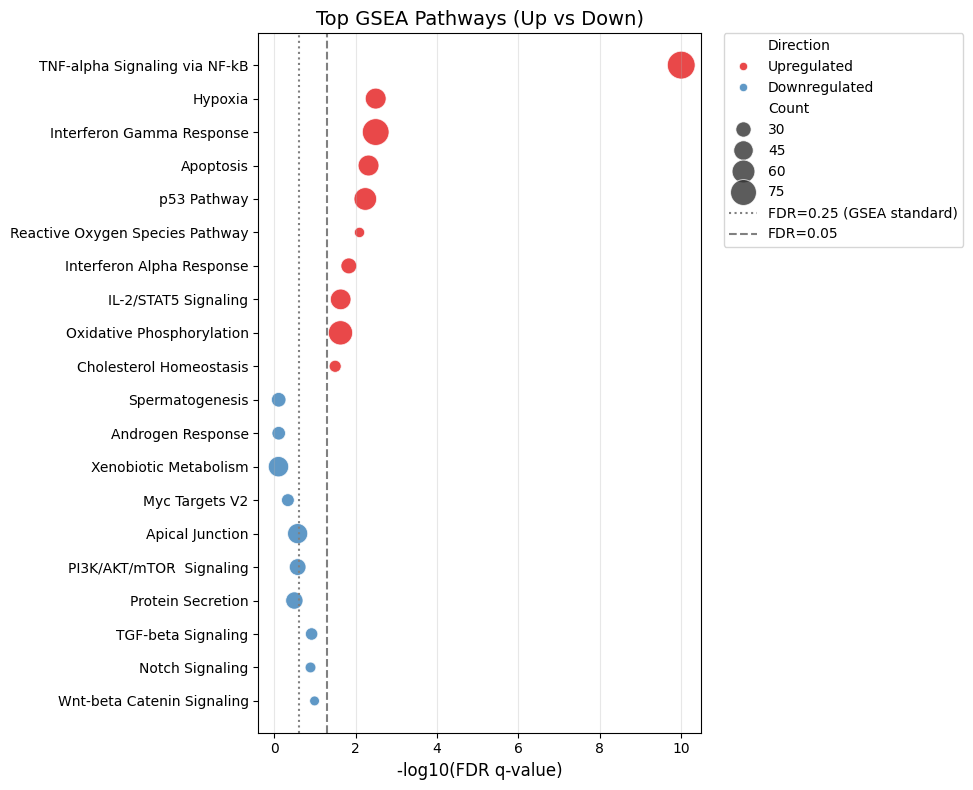

In [41]:
plt.figure(figsize=(10, 8))

# Create the scatter plot
sns.scatterplot(
    data=combined_gsea,
    x='log_FDR',
    y='Term',
    hue='Direction',     # Color by NES Direction
    size='Count',        # Size by number of Leading Edge genes
    palette={'Upregulated': '#E41A1C', 'Downregulated': '#377EB8'}, # Red/Blue
    sizes=(50, 400),     # Range of dot sizes
    alpha=0.8
)

# Customization
plt.title('Top GSEA Pathways (Up vs Down)', fontsize=14)
plt.xlabel('-log10(FDR q-value)', fontsize=12)
plt.ylabel('')

# Add a vertical line for significance (FDR < 0.05 => -log10(0.05) ~= 1.3)
plt.axvline(-np.log10(0.25), color='gray', linestyle=':', label='FDR=0.25 (GSEA standard)')
plt.axvline(-np.log10(0.05), color='gray', linestyle='--', label='FDR=0.05')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.show()

### Enrichr analysis for overrepresentation

In [42]:
# 1. Define your significant gene lists
# Up in Age
up_genes = res[
    (res['padj'] < 0.05) & (res['log2FoldChange'] > 0)
].index.tolist()

# Down in Age
down_genes = res[
    (res['padj'] < 0.05) & (res['log2FoldChange'] < 0)
].index.tolist()

print(f"Analyzing {len(up_genes)} upregulated and {len(down_genes)} downregulated genes.")

# 2. Run Enrichr (Over-Representation Analysis)
if len(up_genes) > 0:
    enr_up = gp.enrichr(
        gene_list=up_genes,
        gene_sets=['MSigDB_Hallmark_2020'],
        organism='human', 
        outdir=None
    )
    print("Upregulated Pathways:")
    print(enr_up.results[['Term', 'Adjusted P-value', 'Overlap']].head(10))
    

if len(down_genes) > 0:
    enr_down = gp.enrichr(
        gene_list=down_genes,
        gene_sets=['MSigDB_Hallmark_2020'],
        organism='human', 
        outdir=None
    )
    print("Downregulated Pathways:")
    print(enr_down.results[['Term', 'Adjusted P-value', 'Overlap']].head(10))
    


Analyzing 1205 upregulated and 1919 downregulated genes.
Upregulated Pathways:
                              Term  Adjusted P-value Overlap
0    TNF-alpha Signaling via NF-kB      3.695219e-15  48/200
1                   Myc Targets V1      2.231576e-13  45/200
2                      p53 Pathway      5.909649e-11  41/200
3                        Apoptosis      6.464364e-11  36/161
4        Interferon Gamma Response      2.287547e-09  38/200
5                          Hypoxia      2.679064e-07  34/200
6        Oxidative Phosphorylation      2.679064e-07  34/200
7  Reactive Oxygen Species Pathway      4.441324e-06   14/49
8        Unfolded Protein Response      1.912995e-05  21/113
9                 mTORC1 Signaling      4.982898e-05  29/200
Downregulated Pathways:
                         Term  Adjusted P-value Overlap
0              Myc Targets V1          0.001618  38/200
1           Protein Secretion          0.005788   21/96
2    PI3K/AKT/mTOR  Signaling          0.005788  22/105
3 

In [43]:

# 1. Add a "Direction" column to distinguish them
up_res = enr_up.results.copy()
up_res['Direction'] = 'Upregulated'
up_res['Color'] = 'Red'  # For custom palette

down_res = enr_down.results.copy()
down_res['Direction'] = 'Downregulated'
down_res['Color'] = 'Blue'

# 2. Filter for top 10 pathways by Adjusted P-value
# (You can also filter by 'Combined Score' if you prefer)
top_up = up_res.sort_values('Adjusted P-value').head(10)
top_down = down_res.sort_values('Adjusted P-value').head(10)

# 3. Concatenate
combined = pd.concat([top_up, top_down])

# 4. Create a "-log10(P-value)" column for plotting
combined['log_p'] = -np.log10(combined['Adjusted P-value'])

# 5. Extract "Count" from the "Overlap" column (e.g., "5/200" -> 5)
# This is used to size the dots
combined['Gene_Count'] = combined['Overlap'].apply(lambda x: int(x.split('/')[0]))

print(f"Plotting {len(combined)} pathways.")


Plotting 20 pathways.


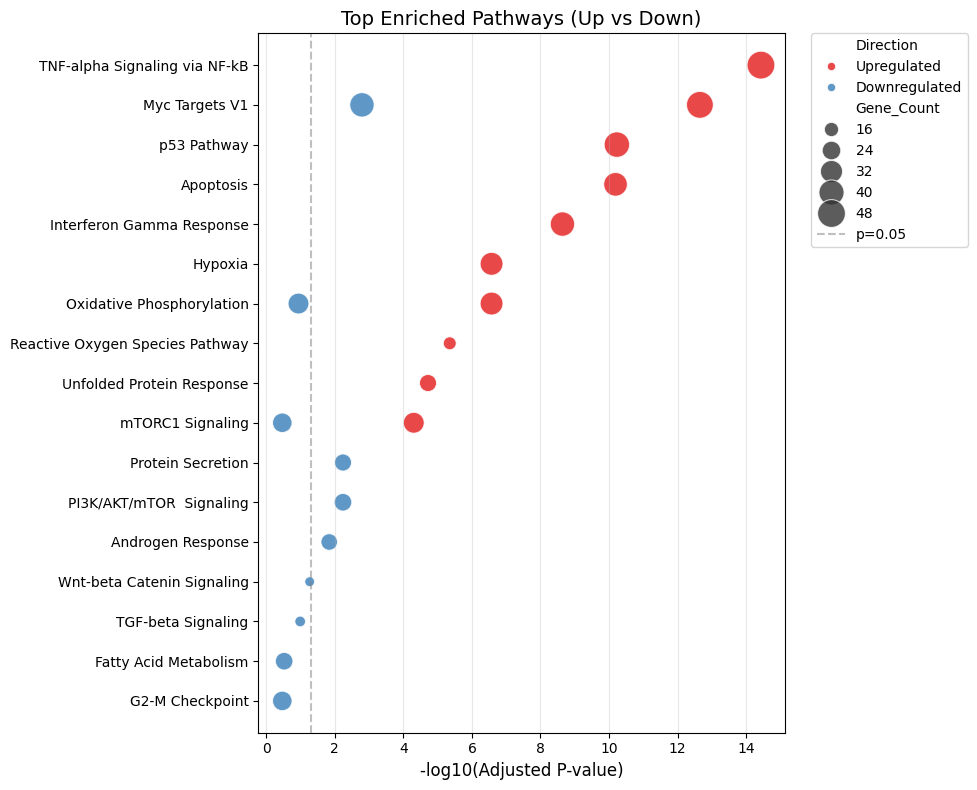

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Create the scatter plot
sns.scatterplot(
    data=combined,
    x='log_p',
    y='Term',
    hue='Direction',    # Color by Up/Down
    size='Gene_Count',  # Size by number of genes in pathway
    palette={'Upregulated': '#E41A1C', 'Downregulated': '#377EB8'}, # Red/Blue
    sizes=(50, 400),    # Range of dot sizes
    alpha=0.8
)

# Customization
plt.title('Top Enriched Pathways (Up vs Down)', fontsize=14)
plt.xlabel('-log10(Adjusted P-value)', fontsize=12)
plt.ylabel('')
plt.axvline(-np.log10(0.05), color='gray', linestyle='--', alpha=0.5, label='p=0.05') # Significance threshold line
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.show()

### Age prediction from gene expression

Here we will build a predictive model and assess our ability to predict age from held-out individuals.  We also test against a baseline model with only sex as a covariate.

In [45]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import numpy as np

# 1. Prepare features and target
# Features: all genes from counts_df_ct + sex variable
X_genes = counts_df_ct.copy()

# Add sex as a binary feature (encode as 0/1)
sex_encoded = pd.get_dummies(metadata_ct['sex'], drop_first=True)
X = pd.concat([X_genes, sex_encoded], axis=1)

# Target: age
y = metadata_ct['age'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Number of samples: {len(y)}")
print(f"Age range: {y.min():.1f} - {y.max():.1f} years")

# 2. Set up ShuffleSplit cross-validation
# Using 5 splits with 20% test size
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# 3. Store results
r2_scores = []
mae_scores = []
predictions_list = []
actual_list = []

# 4. Train and evaluate model for each split
for fold, (train_idx, test_idx) in enumerate(cv.split(X)):
    print(f"\nFold {fold + 1}/5")
    
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale features (important for SVR)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Linear SVR
    # C parameter controls regularization (smaller = more regularization)
    model = LinearSVR(C=1.0, max_iter=10000, random_state=42, dual='auto')
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    r2_scores.append(r2)
    mae_scores.append(mae)
    predictions_list.extend(y_pred)
    actual_list.extend(y_test)
    
    print(f"  R² Score: {r2:.3f}")
    print(f"  MAE: {mae:.2f} years")

# 5. Summary statistics
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)
print(f"R² Score: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f} years")
print("="*50)

Feature matrix shape: (698, 29325)
Number of samples: 698
Age range: 19.0 - 97.0 years

Fold 1/5
  R² Score: 0.310
  MAE: 11.38 years

Fold 2/5
  R² Score: 0.305
  MAE: 11.63 years

Fold 3/5
  R² Score: 0.247
  MAE: 11.94 years

Fold 4/5
  R² Score: 0.314
  MAE: 10.67 years

Fold 5/5
  R² Score: 0.240
  MAE: 10.87 years

CROSS-VALIDATION RESULTS
R² Score: 0.283 ± 0.033
MAE: 11.30 ± 0.47 years


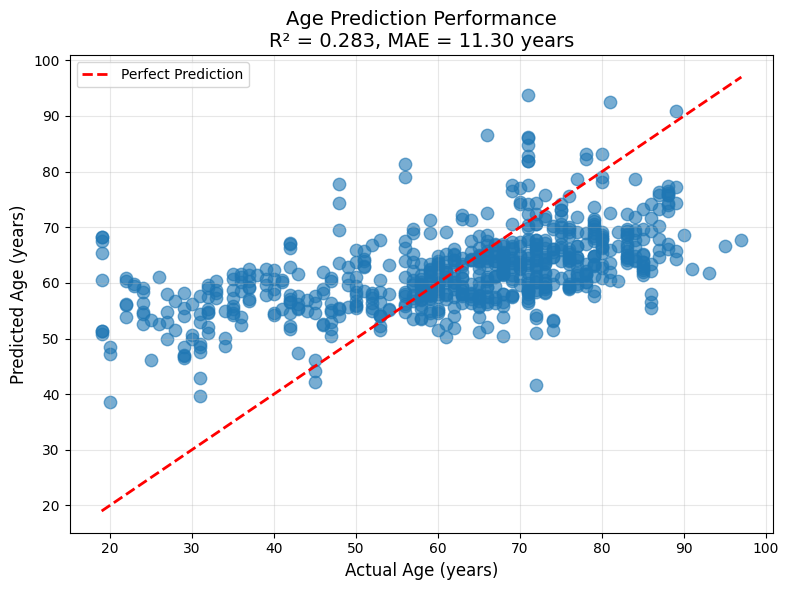

In [46]:
# Visualize predictions vs actual ages
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Scatter plot of predictions vs actual
plt.scatter(actual_list, predictions_list, alpha=0.6, s=80)

# Add diagonal line (perfect predictions)
min_age = min(min(actual_list), min(predictions_list))
max_age = max(max(actual_list), max(predictions_list))
plt.plot([min_age, max_age], [min_age, max_age], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Age (years)', fontsize=12)
plt.ylabel('Predicted Age (years)', fontsize=12)
plt.title(f'Age Prediction Performance\nR² = {np.mean(r2_scores):.3f}, MAE = {np.mean(mae_scores):.2f} years', 
          fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Baseline model: Sex only

Compare against a baseline model that only uses sex as a predictor to assess the contribution of gene expression.

In [47]:
# Baseline model: Sex only
X_baseline = sex_encoded.copy()

# Store baseline results
baseline_r2_scores = []
baseline_mae_scores = []

# Train and evaluate baseline model for each split
for fold, (train_idx, test_idx) in enumerate(cv.split(X_baseline)):
    # Split data
    X_train, X_test = X_baseline.iloc[train_idx], X_baseline.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Linear SVR
    model = LinearSVR(C=1.0, max_iter=10000, random_state=42, dual='auto')
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    baseline_r2_scores.append(r2)
    baseline_mae_scores.append(mae)

# Summary comparison
print("="*60)
print("MODEL COMPARISON")
print("="*60)
print(f"Full Model (Genes + Sex):")
print(f"  R² Score: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"  MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f} years")
print(f"\nBaseline Model (Sex Only):")
print(f"  R² Score: {np.mean(baseline_r2_scores):.3f} ± {np.std(baseline_r2_scores):.3f}")
print(f"  MAE: {np.mean(baseline_mae_scores):.2f} ± {np.std(baseline_mae_scores):.2f} years")
print(f"\nImprovement:")
print(f"  ΔR²: {np.mean(r2_scores) - np.mean(baseline_r2_scores):.3f}")
print(f"  ΔMAE: {np.mean(baseline_mae_scores) - np.mean(mae_scores):.2f} years")
print("="*60)

MODEL COMPARISON
Full Model (Genes + Sex):
  R² Score: 0.283 ± 0.033
  MAE: 11.30 ± 0.47 years

Baseline Model (Sex Only):
  R² Score: -0.027 ± 0.018
  MAE: 13.55 ± 0.54 years

Improvement:
  ΔR²: 0.310
  ΔMAE: 2.25 years
